In [1]:
import matplotlib.pyplot as plt
import scipy.io as spio 
import pandas as pd
import numpy as np
import os
from my_tools import *
from ranked_structural_connectivity import *
import pickle
from IPython.display import Image
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')

In [2]:
def unpickle(where_pkl):
    with open(where_pkl, 'rb') as f:
        return pickle.load(f)
    
class Patient:
    def __init__(self, plot_path,assessment_path,baseline_file,files_to_remove,vta_path):
        self.plot_path = plot_path
        self.assessment_path = assessment_path
        self.baseline_file = baseline_file
        self.files_to_remove = files_to_remove
        self.vta_path = vta_path
        
    def pickle(self, where_pkl):
        pickleFile = open(where_pkl, 'wb')
        pickle.dump(self, pickleFile)
        pickleFile.close()
   


In [3]:
# SAVIOR https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def manual_loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def improvement_df(mat_path):
    raw_mat = manual_loadmat(mat_path)
    mat = {k : el for k, el in raw_mat.items() if k.startswith('session')}
    improvement_df = pd.concat({k: pd.DataFrame.from_dict(v,orient='index').T for k, v in mat.items()})
    improvement_df.index.names = ['date', 'useless']
    improvement_df = improvement_df.reset_index().drop('useless',axis= 1)
    improvement_df['date'] = improvement_df['date'].apply(lambda x : x.split('session_')[1])
    return improvement_df

In [4]:
def find_date_extreme(patient_df, measure, mode):
    # patient_df has as many rows as there are session for the patient
    # 8 columns : date, MDD measures, result of improvement_df
    if mode == 'worst':
        index = patient_df[[measure]].idxmin().item()
    else:
        index = patient_df[[measure]].idxmax().item()
    date_extreme = patient_df.iloc[index][['date',measure]]['date']
    
    return date_extreme

In [5]:
def create_pivoted(patient, parcellation_path_Brodmann, areas,out_path):
    #creates structural connectivity df for all sessions, all BA
    sorted_code_list = np.load(patient.plot_path + '/sorted_code_list.npy')
    sorted_code_list = ['VTA_' + "{0:0=2d}".format(i) for i in sorted_code_list]
    loaded_stimulation_dicts = np.load(patient.assessment_path + '/corrected_stimulations.npy', allow_pickle='TRUE')

    dates = np.load(patient.plot_path + '/sorted_dates.npy')
    df = read_assessments(dates, patient.assessment_path, patient.baseline_file, patient.files_to_remove)
    all_measures = {'{}'.format(scale): df[df.measure == scale] for scale in list(df.measure.unique())}
    ranks = all_ranks(all_measures)
    mode = 'Brodmann' #maybe we will like the Dkt at some point
    labels = get_labels(parcellation_path_Brodmann, mode)
    # for side in ['left','right']:
    bilateral_df = bilateral_video(labels, patient.vta_path, dates, sorted_code_list)
    piv = visualize_connectivity(bilateral_df, 8, out_path, show=False)
    #piv['date'] = piv.apply(lambda x : pd.to_datetime(x.date,format = '%d.%m.%Y'),axis=1)
    return piv

In [6]:
def line_df(id_pat, pivoted, global_patient, measure, mode):
    
    date_extreme = find_date_extreme(global_patient, measure, mode)
    value_extreme = global_patient[global_patient.date ==date_extreme][measure].item()
    print('for', id_pat, 'the ', mode, 'VTA for measure ', measure, 'is at the date', date_extreme, 'with % improvement', value_extreme)
    df = pivoted[pivoted.date == pd.to_datetime(date_extreme,format = '%d_%m_%Y')]
    df.index = [id_pat]
    df['%impro'] = value_extreme
    return df, {id_pat : date_extreme}

In [7]:
def intersubjects(measure, mode, id_piv_dict, id_global_dict):
    df_n_dates = [ line_df(patient_id, pivoted_table, id_global_dict[patient_id], measure, mode) for patient_id, pivoted_table in id_piv_dict.items()]
    frames = [el[0] for el in df_n_dates ]
    dates_extremes = {k : v for el in df_n_dates for k, v in el[1].items()}
    return pd.concat(frames, sort=False), dates_extremes

In [8]:
def plot_connectivity_comparison(dataframe, save_dir, measure, mode):
    # dataframe has as many rows as there are sessions, the date column and one more column than numb (used in minimize )
    
    fig, ax = plt.subplots(figsize=(6, 8))

    dataframe['date'] = dataframe.apply(lambda x: pd.to_datetime(x.date, format='%d.%m.%Y'), axis=1)  # datetime
    dataframe = dataframe.sort_values(by='date')

    dataframe['date'] = dataframe.date.dt.strftime('%d-%m-%Y')
    x = [name+'\n'+str(perc)+'%' for name, perc in zip(dataframe.index,dataframe['%impro'])]
#     x = dataframe.index
#     y = dataframe['%impro']
#     print('ppppppppppppppp', [name+'\n'+str(perc) for name, perc in zip(x,y)])
    to_use = dataframe.drop(['date','%impro'],axis=1).fillna(0)

    cmap = plt.cm.tab20
    rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(to_use.columns))))
    mpp_colors = dict(zip(to_use.columns, rcParams['axes.prop_cycle'].by_key()['color']))

    indexes = np.argsort(to_use.values).T  # row by row get order, then transpose
    heights = np.sort(to_use.values).T  # sorts row by row, then transpose
    order = -1
    bottoms = heights[::order].cumsum(
        axis=0)  # reads heights from bottom row to first row, then second row is sum first + second ecc
    bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)  # adds a first row of zeros
    for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):
        mps = np.take(np.array(to_use.columns), idxs)  # get name of column at idxs
        ax.bar(x, height=vals, bottom=bottoms[btms], color=[mpp_colors[m] for m in mps])


    ax.set_ylim(bottom=0, top=102)
    plt.legend((np.take(np.array(to_use.columns), np.argsort(to_use.values)[0]))[::order], loc='center right',
               bbox_to_anchor=(1.40, 0.5), fancybox=True,
               shadow=True, title='Brodmann area')
    plt.xticks(rotation=45)
    plt.title('{mod} VTA for measure {mea} across subjects'.format(mod = mode.capitalize(), mea = measure))
    plt.xlabel('Patient')
    plt.ylabel('% connectivity')
    plt.show()
    #plt.savefig(os.path.join(save_dir, 'Time_sorted_VTAs'), bbox_inches="tight")

    return

In [9]:
def date_to_VTA_code(date, patient):
    all_dates = np.load(patient.plot_path+'/sorted_dates.npy')
    all_codes =  np.load(patient.plot_path+'/sorted_code_list.npy')
    index_date = np.argwhere(all_dates == date.replace('_','.')).item()
    unique_VTA_code = all_codes[index_date]
    unique_VTA_code_string = 'VTA_' + "{0:0=2d}".format(unique_VTA_code)
    
    return unique_VTA_code_string #Image(filename=os.path.join(patient.vta_path, unique_VTA_code_string, 'Bimodal_connectivity_{}.png'.format(unique_VTA_code_string)))

In [10]:
def bimodal_connectivity(bimodal, VTA_name, destination_folder=False, sorting=False, scaling=False, custom_title = False):
    # define 4 color-blind friendly colors from https://gist.github.com/thriveth/8560036
    col1 = '#377eb8'
    col2 = '#ff7f00'
    col3 = '#4daf4a'
    col4 = '#a65628'

    if sorting:
        bimodal = bimodal.sort_values(by='sum_of_weight')

    fig, ax = plt.subplots(figsize=(18, 5))
    if custom_title:
        plt.title(custom_title, fontsize=18)
    else:
        plt.title('Structural and functional connectivity for {}'.format(VTA_name), fontsize=18)

    # using the twinx() for creating another
    # axes object for secondary y-Axis
    ax2 = ax.twinx()

    # Functional
    col = np.where(bimodal.average_value < 0, col1, col2)
    ax.scatter(bimodal.label, abs(bimodal.average_value), c=col)
    if scaling:
        max_functional = max(abs(bimodal.average_value)) + max(abs(bimodal.average_value)) * 0.1
        ax.set_ylim([0, max_functional])
    else:
        ax.set_ylim([0, 0.5])

    # giving labels to the axes
    ax.set_xlabel('Brodmann Area')
    ax.set_ylabel('Mean functional connection of BA to VTA', color=col3, weight='bold')
    ax.set_xticklabels(bimodal.label, rotation=70)
    ax.tick_params(axis='y', colors=col3)
    # Structural
    if scaling:
        max_structural = max(bimodal.perc) + max(bimodal.perc) * 0.1
        ax2.set_ylim([0, max_structural])
    else:
        ax2.set_ylim([0, 100])

    ax2.bar(bimodal.label, bimodal.perc, label='Structural connectivity', color='b', alpha=0.2)
    positive = mlines.Line2D([], [], color=col1, marker='.',
                             markersize=15, label='Positive functional connectivity')
    negative = mlines.Line2D([], [], color=col2, marker='.',
                             markersize=15, label='Negative functional connectivity')

    ax2.set_ylabel('% weights VTA to BA', color=col4, weight='bold')
    ax2.tick_params(axis='y', colors=col4)

    # where some data has already been plotted to ax
    handles, labels = ax2.get_legend_handles_labels()

    # handles is a list, so append manual patch
    handles.append(positive)
    handles.append(negative)

    plt.legend(handles=handles, bbox_to_anchor=(1.25, 0.95), fancybox=True,
               shadow=True)
    # defining display layout

    if destination_folder:
        plt.savefig(os.path.join(destination_folder, 'Bimodal_connectivity_{}'.format(VTA_name)), bbox_inches='tight')
    else:
        plt.show()
    return

In [11]:
#refactoring bimodal_plot main
def bimodal_plot_main(patient, parcellation_path_Brodmann, VTA_code):
#     VTA_tracts_path = os.path.join(patient.patient_path, 'VTA_tracts')
    VTA_tracts = sorted([el for el in os.listdir(patient.vta_path) if el.startswith('VTA')])
    # loaded_stimulation_dicts = np.load(assessment_path + '/corrected_stimulations.npy', allow_pickle='TRUE')
    # get sequence of unique VTA codes in time
    sorted_code_list = np.load(patient.plot_path + '/sorted_code_list.npy')
    sorted_code_list = ['VTA_' + "{0:0=2d}".format(i) for i in sorted_code_list]
    # get sequence of dates
    dates = np.load(patient.plot_path + '/sorted_dates.npy')  # string with dd.mm.yyyy format
    labels = get_labels(parcellation_path_Brodmann, 'Brodmann')

    together = bilateral_video(labels, patient.vta_path, dates, sorted_code_list)

    date_to_code = dict(zip(dates, sorted_code_list))
    together['unique_VTA_code'] = together.apply(lambda x: date_to_code[x.date], axis=1)
    together.drop_duplicates(subset=['area', 'sum_of_weight', 'unique_VTA_code'], inplace=True)

    structural = together[together.unique_VTA_code == VTA_code.split('/')[-1]]

    functional = pd.read_csv(os.path.join(patient.vta_path,VTA_code, 'averaged_z_fingerprint.txt'), sep=' ')

    bimodal = functional.merge(structural, left_on='label', right_on='area')

    total_weight_day = bimodal.groupby(['date']).sum().to_dict()['sum_of_weight']
    bimodal['perc'] = bimodal.apply(lambda x: (x.sum_of_weight / total_weight_day[x.date]) * 100, axis=1)
    #bimodal_connectivity(bimodal, patient.VTA_code.split('/')[-1], patient.save_path, sorting=True, scaling=False)
    return bimodal

## Create Patient instances 

In [12]:
plot_path = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/Patient3/VTA_tracts/plot'
assessment_path = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/Patient3/Bamert_Bettina_1956-08-14/Assessments'
baseline_file = 'baseline_summary.xlsm'
files_to_remove = ''
parcellation_path_Brodmann = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/AtlasCollection/Brodmann/Brodmann_known_default.txt'
vta_path = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/Patient3/VTA_tracts'

In [13]:
Pat3 = Patient(plot_path,assessment_path,baseline_file,files_to_remove,vta_path)
Pat3.pickle('Pat3.pkl')

In [14]:
plot_path = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/Patient1/VTA_tracts/plot'
assessment_path = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/Patient1/Rohrer_Daniela_1979-03-08/Assessments'
baseline_file = 'Rohrer_Daniela_1979-03-08_Depressionassessments_2018-09-10.xlsm'
files_to_remove = 'Rohrer_Daniela_1979-03-08_hochfrequente Assessments_2018-10-1.xlsm'
parcellation_path_Brodmann = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/AtlasCollection/Brodmann/Brodmann_known_default.txt'
vta_path = '/media/brainstimmaps/DATA/20xx_Projects/2025_DBSinDepression/03_Data/Patient1/VTA_tracts'

In [15]:
Pat1 = Patient(plot_path,assessment_path,baseline_file,files_to_remove,vta_path)
Pat1.pickle('Pat1.pkl')

### Create improvement DF

In [16]:
pat1_df = improvement_df(Pat1.assessment_path+'/perc_impro.mat')
#pat2_df = improvement_df(Pat2.assessment_path+'/perc_impro.mat')
pat3_df = improvement_df(Pat3.assessment_path+'/perc_impro.mat')

### Create structural dataframe

In [17]:
piv1 = create_pivoted(Pat1,parcellation_path_Brodmann,8,'.')
piv3 = create_pivoted(Pat3,parcellation_path_Brodmann,8,'.')

10.09.2018 has nan LEFT stimulation
10.09.2018 has nan ROIGHT stimulation
10.09.2018 has nan LEFT stimulation
10.09.2018 has nan ROIGHT stimulation
14.09.2018 has nan LEFT stimulation
14.09.2018 has nan ROIGHT stimulation
20.09.2019 has nan LEFT stimulation
20.09.2019 has nan ROIGHT stimulation
20.09.2019 has nan LEFT stimulation
20.09.2019 has nan ROIGHT stimulation


### Store info in dicts

In [18]:
id_piv_dict = {'Patient1':piv1, 'Patient3':piv3}
id_global_dict = {'Patient1':pat1_df, 'Patient3':pat3_df}
id_patient_dict =  {'Patient1':Pat1, 'Patient3':Pat3}

In [19]:
modality = 'worst'
measure = 'MADRS'

In [25]:
def intersubjects_connectivity_summary(measure,modality, id_piv_dict, id_global_dict, id_patient_dict,parcellation_path_Brodmann):
    both, dates_extr = intersubjects(measure,modality, id_piv_dict, id_global_dict)
    plot_connectivity_comparison(both, 'future_save_directory', measure,modality)
    for patientID, date in dates_extr.items():
        vta_code = date_to_VTA_code(date, id_patient_dict[patientID])
        bimodal_df =  bimodal_plot_main(id_patient_dict[patientID], parcellation_path_Brodmann, vta_code)
        bimodal_connectivity(bimodal_df, vta_code, destination_folder=False, sorting=True, scaling=False, custom_title='{mode} bimodal connectivity for {patientid} on measure {measure}'.format(mode = modality.capitalize(), patientid=patientID, measure= measure))

    return
    

for Patient1 the  best VTA for measure  MADRS is at the date 26_05_2020 with % improvement 61.67
for Patient3 the  best VTA for measure  MADRS is at the date 22_07_2020 with % improvement 21.66


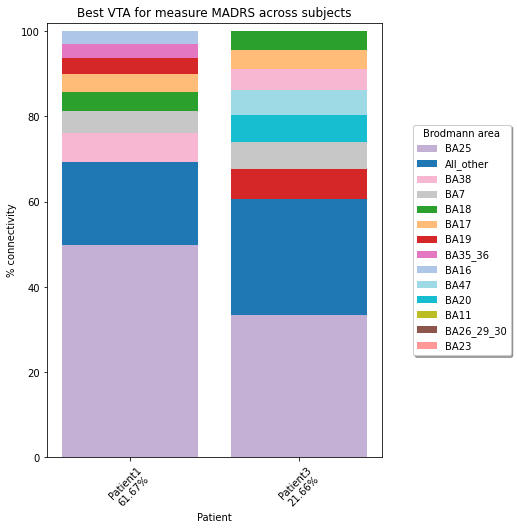

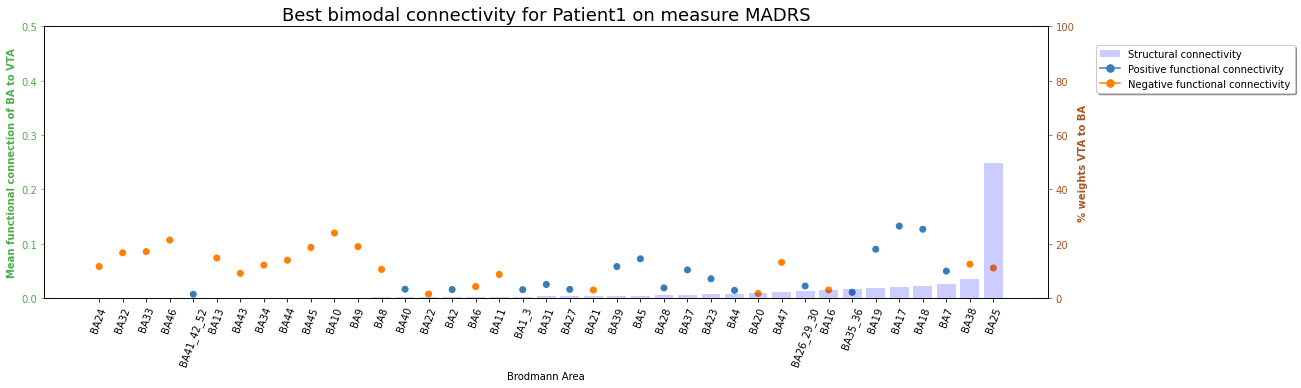

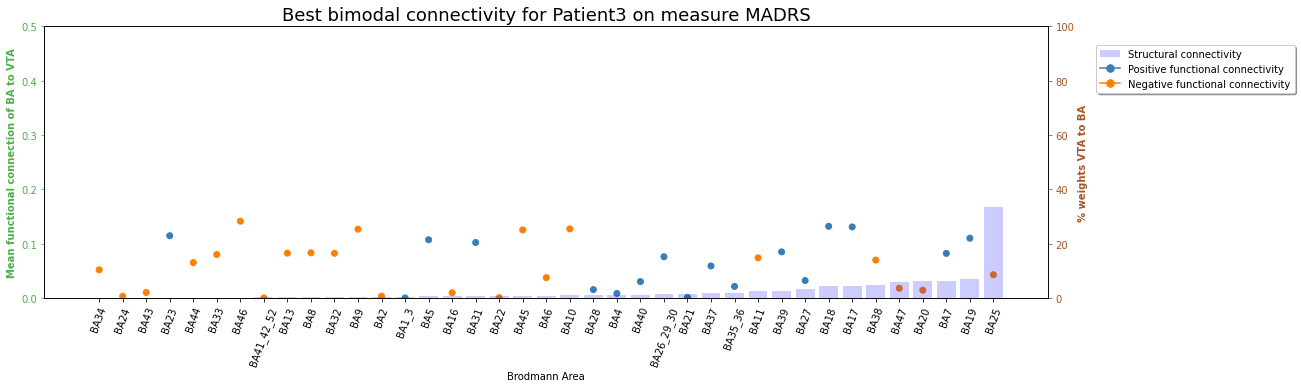

In [26]:
intersubjects_connectivity_summary('MADRS','best', id_piv_dict, id_global_dict, id_patient_dict,parcellation_path_Brodmann)

for Patient1 the  best VTA for measure  SHAPS is at the date 18_01_2019 with % improvement 78.57
for Patient3 the  best VTA for measure  SHAPS is at the date 04_12_2019 with % improvement 7.14


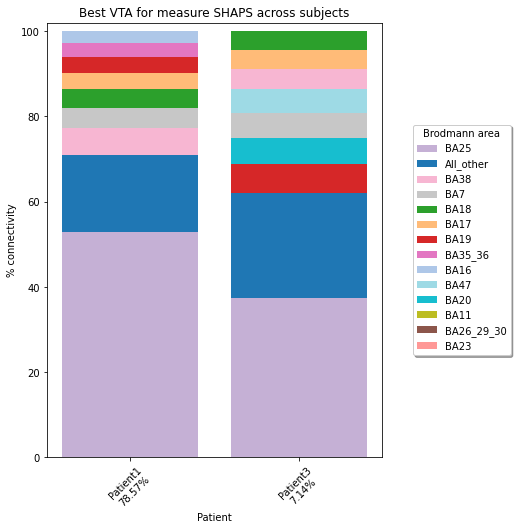

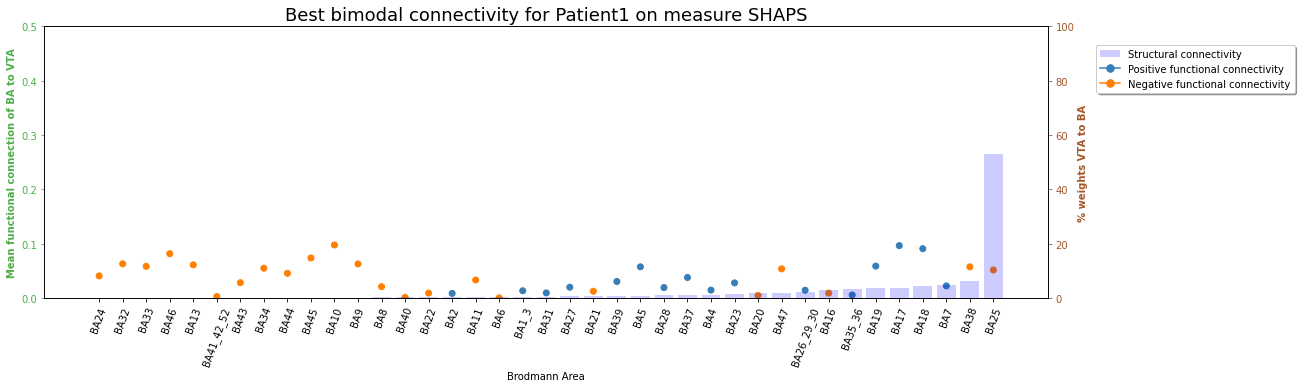

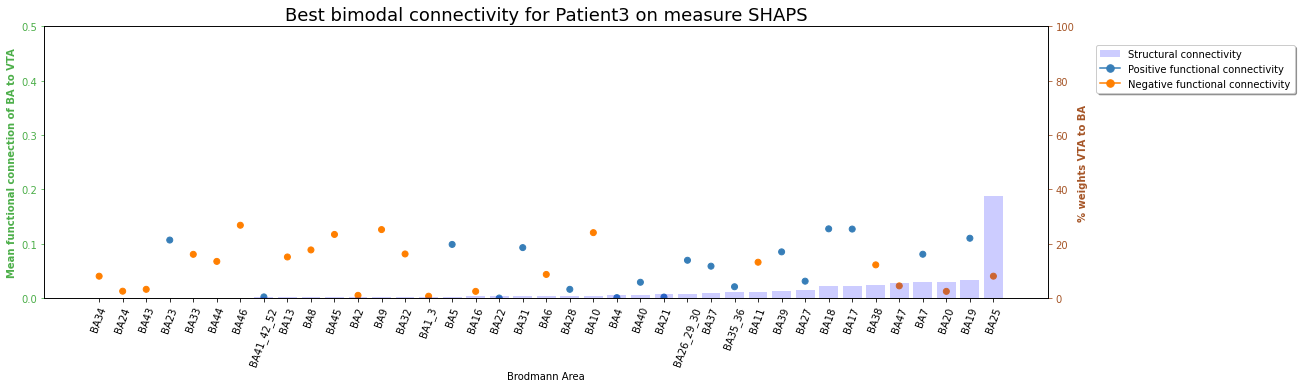

In [27]:
intersubjects_connectivity_summary('SHAPS','best', id_piv_dict, id_global_dict, id_patient_dict,parcellation_path_Brodmann)

for Patient1 the  worst VTA for measure  SHAPS is at the date 01_10_2018 with % improvement -14.29
for Patient3 the  worst VTA for measure  SHAPS is at the date 05_11_2019 with % improvement -42.86


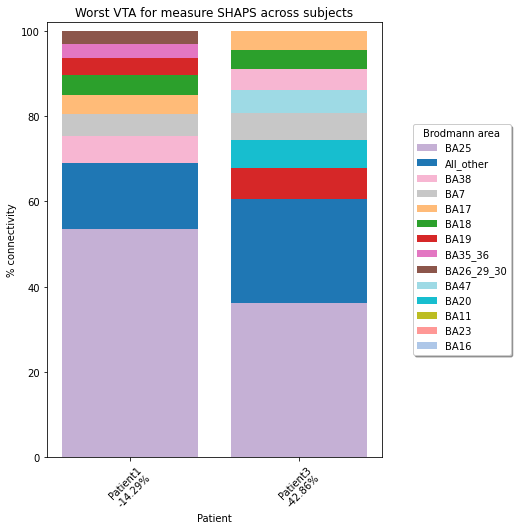

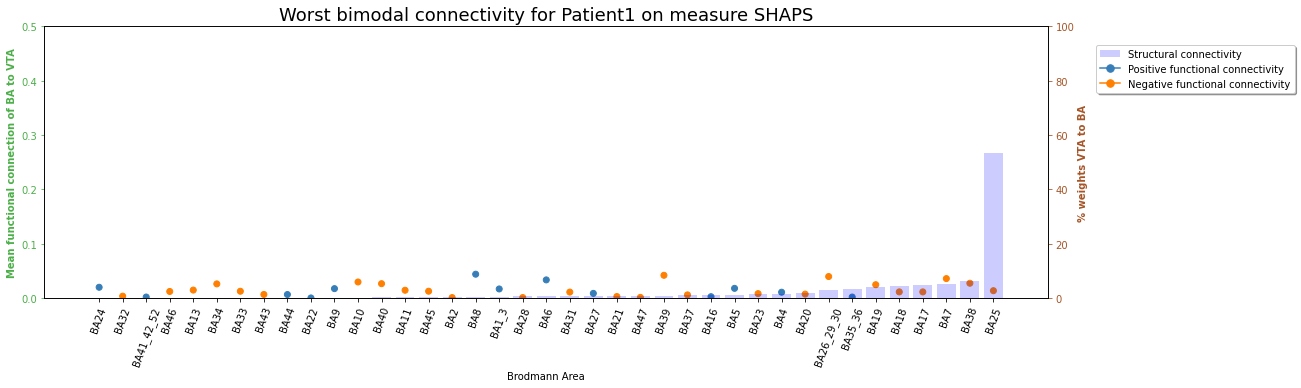

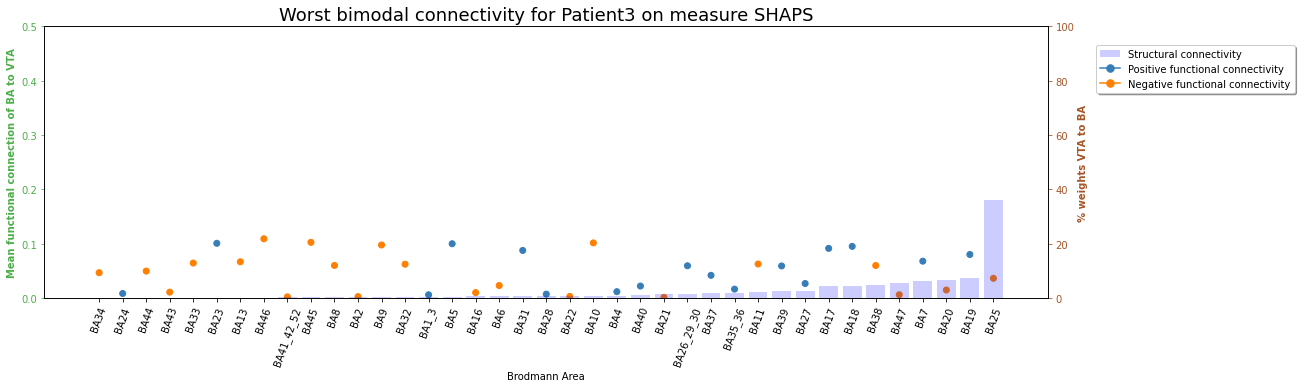

In [28]:
intersubjects_connectivity_summary('SHAPS','worst', id_piv_dict, id_global_dict, id_patient_dict,parcellation_path_Brodmann)